# Model Deep Learning Klasifikasi Sampah Organik dan Daur Ulang

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Testing GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('Device GPU not Found')
print('Gpu found at: {}' .format(device_name) )

Gpu found at: /device:GPU:0


In [3]:
!pip install unrar

In [4]:
!unrar x /content/drive/MyDrive/Dataset/Dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  Dataset/Train/R/R_55.jpg                                      83%  OK 
Extracting  Dataset/Train/R/R_550.jpg                                     83%  OK 
Extracting  Dataset/Train/R/R_5500.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5501.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5502.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5503.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5504.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5505.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5506.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R_5507.jpg                                    83%  OK 
Extracting  Dataset/Train/R/R

In [5]:
# Dependencies

import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

## Data Structure
Data source: https://www.kaggle.com/techsash/waste-classification-data

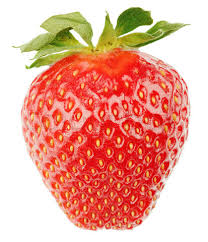

In [6]:
#check gambar folder Train Organik
display.Image('/content/Dataset/Train/O/O_1.jpg', width = 300, height = 300)

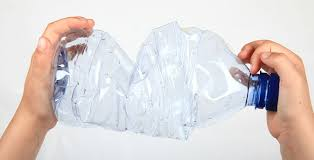

In [7]:
#check gambar folder Train Recycle
display.Image('/content/Dataset/Train/R/R_1.jpg', width = 300, height = 300)

In [8]:
# Membuat Direktori Path

base_dir = "/content/Dataset"
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")

In [9]:
# Os path join (train)
train_o = glob.glob(os.path.join(train_dir, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(train_dir, 'R', '*.jpg'))

a = len(train_o)
b = len(train_r)

print("Number of training samples: {}".format(a+b))
print("Number of training samples drive 0rganic: {}".format(a))
print("Number of training samples drive Recycle: {}".format(b))

Number of training samples: 22564
Number of training samples drive 0rganic: 12565
Number of training samples drive Recycle: 9999


In [10]:
# Os path join (test)
test_o = glob.glob(os.path.join(test_dir, 'O', '*.jpg'))
test_r = glob.glob(os.path.join(test_dir, 'R', '*.jpg'))

a = len(test_o)
b = len(test_r)

print("Number of test samples: {}".format(a+b))
print("Number of Test samples drive 0rganic: {}".format(a))
print("Number of Test samples drive Recycle: {}".format(b))

Number of test samples: 2513
Number of Test samples drive 0rganic: 1401
Number of Test samples drive Recycle: 1112


In [16]:
# Data Generators
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True)
test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.1)
valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.1)

#Train Dataset

In [17]:
# Train dataset
train_ds  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (180, 180),
                                                   class_mode = 'categorical',
                                                   batch_size = 32,
                                                   subset = 'training')

Found 22564 images belonging to 2 classes.


#Validate Dataset

In [18]:
# Validate dataset

valid_ds = valid_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  subset = 'validation')

Found 251 images belonging to 2 classes.


In [19]:
# Test dataset

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle=False)

Found 2513 images belonging to 2 classes.


#Test Dataset


In [20]:
# Check classes

print(train_ds.class_indices)
print(test_ds.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


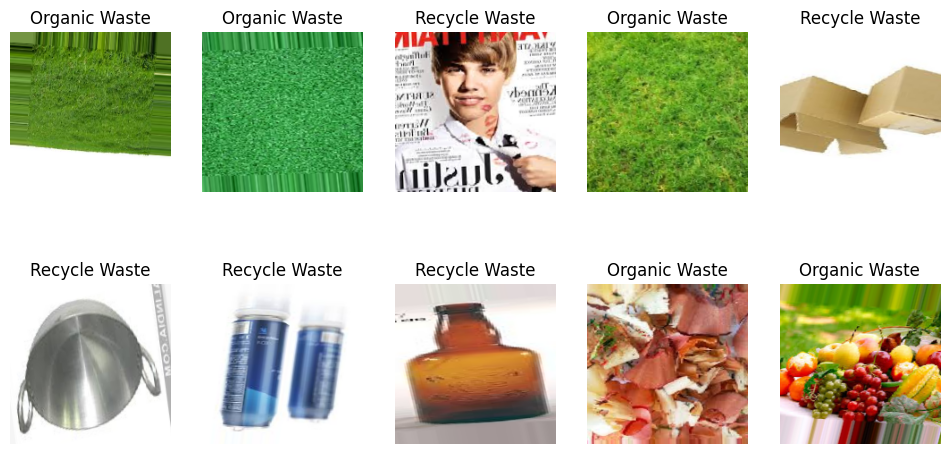

In [22]:
# Viewing images

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,6))
#plt.subplots_adjust(hspace=0.55)

for i in range(2):
    for j in range(5):
        rand1 = np.random.randint(len(train_ds))
        rand2 = np.random.randint(32)
        ax[i,j].imshow(train_ds[rand1][0][rand2])
        ax[i,j].axis('off')
        label = train_ds[rand1][1][rand2]
        # print(label[0])
        if label[0] == 0:
            ax[i,j].set_title('Recycle Waste')
        else:
            ax[i,j].set_title('Organic Waste')

plt.tight_layout
plt.show()

# Building The Model

In [23]:
# Defining callbacks

save_model = '/content/drive/MyDrive/fixmodel/final_model9010.h5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(save_model ,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

#Model VGG16

In [24]:
# Base model
base_model = VGG16(input_shape=(180,180,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
# Freezing layers

for layer in base_model.layers:
    layer.trainable=False

In [26]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#Model Sequential


In [27]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())

# Add dense layers
model.add(BatchNormalization())
model.add(Dense(256,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu",kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

In [28]:
# Show model summary (with custom layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 batch_normalization (BatchN  (None, 12800)            51200     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

## Model Training

In [29]:
# Model fit (training)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(name = 'auc')])
model_history = model.fit(train_ds, epochs=25, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

Epoch 1/25
706/706 [==============================] - ETA: 0s - loss: 0.4032 - auc: 0.9072
Epoch 1: val_auc improved from -inf to 0.97981, saving model to /content/drive/MyDrive/fixmodel/final_model9010.h5
706/706 [==============================] - 233s 303ms/step - loss: 0.4032 - auc: 0.9072 - val_loss: 0.2046 - val_auc: 0.9798
Epoch 2/25
706/706 [==============================] - ETA: 0s - loss: 0.3155 - auc: 0.9394
Epoch 2: val_auc did not improve from 0.97981
706/706 [==============================] - 211s 299ms/step - loss: 0.3155 - auc: 0.9394 - val_loss: 0.1851 - val_auc: 0.9793
Epoch 3/25
706/706 [==============================] - ETA: 0s - loss: 0.2911 - auc: 0.9485
Epoch 3: val_auc did not improve from 0.97981
706/706 [==============================] - 212s 300ms/step - loss: 0.2911 - auc: 0.9485 - val_loss: 0.1943 - val_auc: 0.9776
Epoch 4/25
706/706 [==============================] - ETA: 0s - loss: 0.2852 - auc: 0.9505
Epoch 4: val_auc improved from 0.97981 to 0.98152, sav

In [30]:
# Storing loss and accuracy values into a DataFrame to save permanently for plots
# Store model.fit results in a variable
history = model_history

# Save as DataFrame:
history_df = pd.DataFrame(history.history)
history_df

loss       auc  val_loss   val_auc
0   0.403218  0.907242  0.204556  0.979810
1   0.315473  0.939436  0.185056  0.979302
2   0.291050  0.948492  0.194256  0.977604
3   0.285200  0.950521  0.192221  0.981524
4   0.276478  0.953459  0.153868  0.986318
5   0.269503  0.955682  0.129752  0.992508
6   0.264063  0.957438  0.162014  0.983953
7   0.254881  0.960341  0.176052  0.979667
8   0.252080  0.961177  0.142028  0.989365
9   0.242942  0.963898  0.144166  0.987064
10  0.243621  0.963786  0.129771  0.989254

In [31]:
# Save as csv
history_df.to_csv('/content/drive/MyDrive/fixmodel/finalmodel_history9010.csv', index=False)

In [32]:
# Import csv
model_history = pd.read_csv ('/content/drive/MyDrive/fixmodel/finalmodel_history9010.csv')
model_history

loss       auc  val_loss   val_auc
0   0.403218  0.907242  0.204556  0.979810
1   0.315473  0.939436  0.185056  0.979302
2   0.291050  0.948492  0.194256  0.977604
3   0.285200  0.950521  0.192221  0.981524
4   0.276478  0.953459  0.153868  0.986318
5   0.269503  0.955682  0.129752  0.992508
6   0.264063  0.957438  0.162014  0.983953
7   0.254881  0.960341  0.176052  0.979667
8   0.252080  0.961177  0.142028  0.989365
9   0.242942  0.963898  0.144166  0.987064
10  0.243621  0.963786  0.129771  0.989254

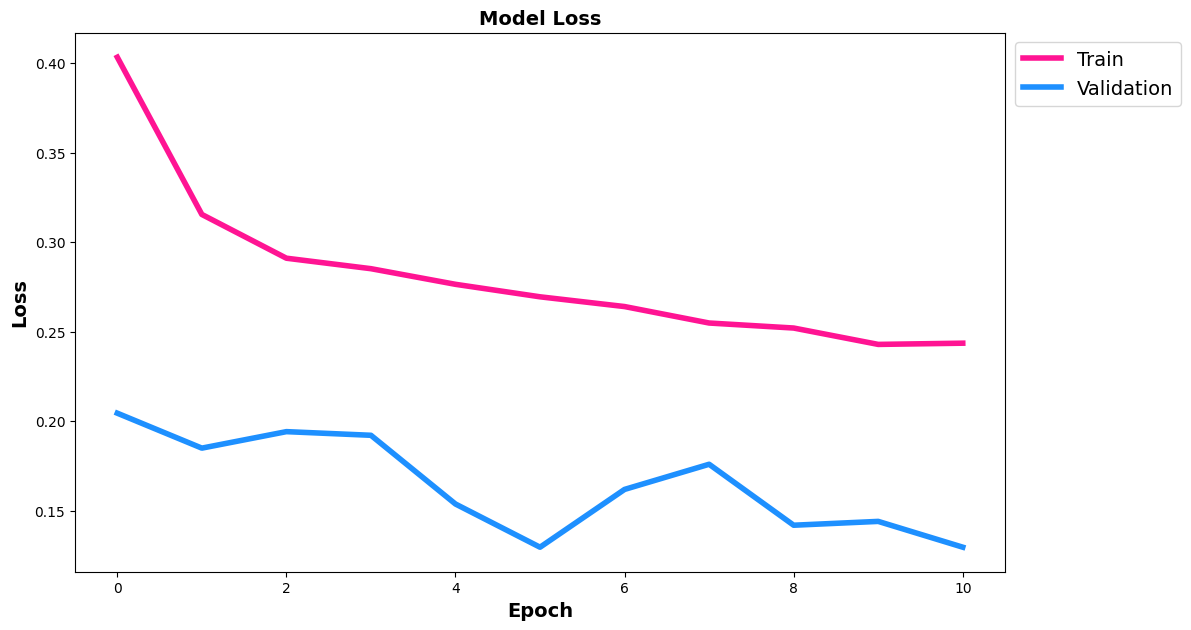

In [33]:
# Plot model loss

plt.figure(figsize=(12,7))
plt.plot(model_history['loss'], color='deeppink', linewidth=4)
plt.plot(model_history['val_loss'], color='dodgerblue', linewidth=4)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

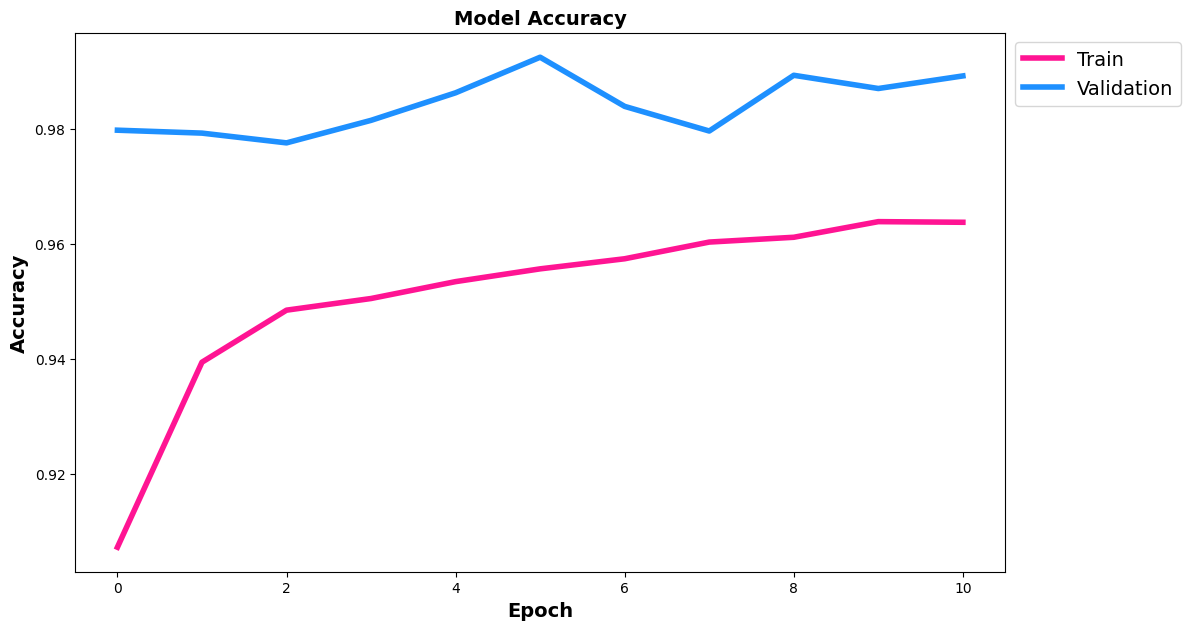

In [34]:
# Plot the model accuracy

plt.figure(figsize=(12,7))
plt.plot(model_history['auc'], color='deeppink', linewidth=4)
plt.plot(model_history['val_auc'], color='dodgerblue', linewidth=4)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

Found 2513 images belonging to 2 classes.
79/79 [==============================] - 8s 106ms/step


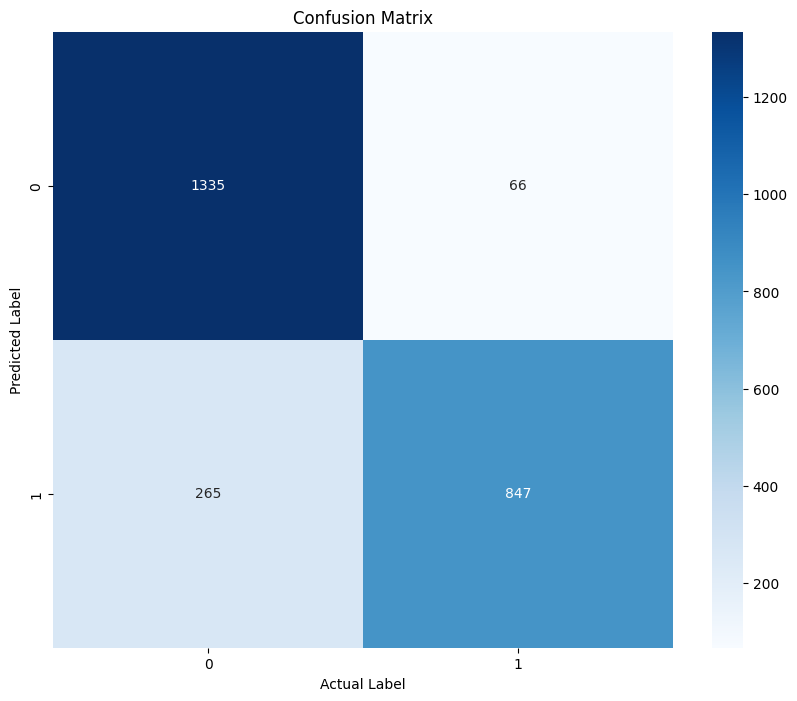

Accuracy: 86.83%
Precision: 87.57%
Recall: 86.83%
F1-score: 86.62%


In [38]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load dataset
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/Dataset/Test',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Load model yang telah dilatih sebelumnya
model = load_model('/content/drive/MyDrive/fixmodel/final_model9010.h5')

# Melakukan prediksi pada data test
predictions = model.predict(test_data, verbose=1)

# Mengubah hasil prediksi ke dalam bentuk label kelas
predicted_classes = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari data test
true_classes = test_data.classes

# Menghitung metrik evaluasi
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.arange(2), yticklabels=np.arange(2))
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Menghitung metrik evaluasi
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))
print('F1-score: {:.2f}%'.format(f1*100))

In [39]:
import numpy as np
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, digits=2)

# Print classification report
print(report)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1401
           1       0.93      0.76      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.86      0.86      2513
weighted avg       0.88      0.87      0.87      2513



1/1 [==============================] - 0s 203ms/step


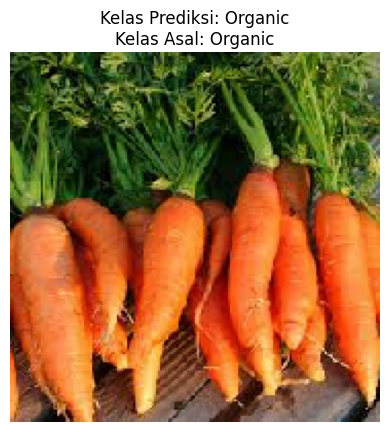

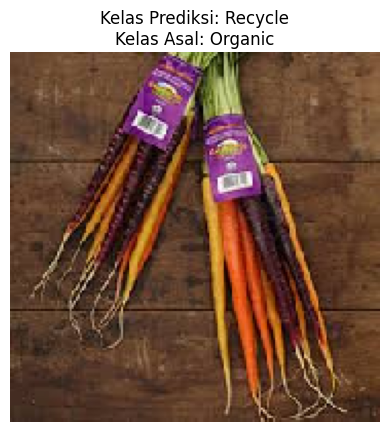

Akurasi keseluruhan: 0.8682849184241942
Jumlah Prediksi Benar: 2182
Jumlah Prediksi Salah: 331


In [40]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np

# Load model yang telah dilatih sebelumnya
model = load_model('/content/drive/MyDrive/fixmodel/final_model9010.h5')
class_names = ['Organic','Recycle']

# Membuat dictionary untuk menyimpan gambar, nilai akurasi, kelas asal, jumlah data benar, dan jumlah data salah untuk setiap kelas
class_data = {class_name: {'image': None, 'accuracy': None, 'original_class': None, 'correct_count': 0, 'wrong_count': 0} for class_name in class_names}

# Mendapatkan prediksi kelas dari model
num_samples = int(len(test_ds))  # Mengambil 20% data dari data test
val_data = [test_ds[i] for i in range(num_samples)]

# Menyimpan hasil prediksi dan label asli untuk semua gambar
all_true_labels = []
all_predicted_labels = []

# Menampilkan hasil prediksi untuk setiap gambar
for data in val_data:
    images = data[0]
    true_labels = data[1]

    # Lakukan prediksi menggunakan model Anda
    predicted_labels = model.predict(images)
    predicted_labels = np.round(predicted_labels)  # Melakukan pembulatan untuk memperoleh prediksi biner

    # Menyimpan label prediksi dan label asli untuk semua gambar
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

    # Menampilkan setiap gambar dalam batch
    for i in range(images.shape[0]):
        image = images[i]
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        # Mendapatkan kelas yang diprediksi dan kelas asli dalam bentuk array biner
        predicted_classes = np.where(predicted_label == 1)[0]
        true_classes = np.where(true_label == 1)[0]

        # Mendapatkan nama kelas yang diprediksi dan kelas asli
        predicted_class_names = [class_names[idx] for idx in predicted_classes if idx < len(class_names)]
        true_class_names = [class_names[idx] for idx in true_classes if idx < len(class_names)]

       # Menyimpan gambar, nilai akurasi, dan kelas asal untuk setiap kelas
        for class_name in predicted_class_names:
            if class_data[class_name]['image'] is None:
                class_data[class_name]['image'] = image
                class_data[class_name]['accuracy'] = accuracy_score(true_label, predicted_label)
                class_data[class_name]['original_class'] = true_class_names[0] if true_class_names else "Unknown"
                class_data[class_name]['correct_count'] = class_data[class_name]['correct_count'] + 1 if true_class_names and class_name in true_class_names else class_data[class_name]['correct_count']
                class_data[class_name]['wrong_count'] = class_data[class_name]['wrong_count'] + 1 if true_class_names and class_name not in true_class_names else class_data[class_name]['wrong_count']

# Menampilkan gambar, keterangan kelas yang diprediksi, nilai akurasi, jumlah data benar, jumlah data salah, dan kelas asal untuk setiap kelas
for class_name, data in class_data.items():
    image = data['image']
    accuracy = data['accuracy']
    original_class = data['original_class']
    correct_count = data['correct_count']
    wrong_count = data['wrong_count']

    plt.imshow(image)
    plt.axis('off')
    plt.title("Kelas Prediksi: " + class_name + "\nKelas Asal: " + original_class)
    plt.show()

# Menghitung dan mencetak akurasi keseluruhan
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
print("Akurasi keseluruhan:", accuracy)

# Menghitung jumlah prediksi benar dari val_generator
total_correct = accuracy_score(all_true_labels, all_predicted_labels, normalize=False)
total_samples = len(all_true_labels)
total_wrong = total_samples - total_correct

print("Jumlah Prediksi Benar:", total_correct)
print("Jumlah Prediksi Salah:", total_wrong)

1/1 [==============================] - 0s 318ms/step
Hasil Prediksi Benar:


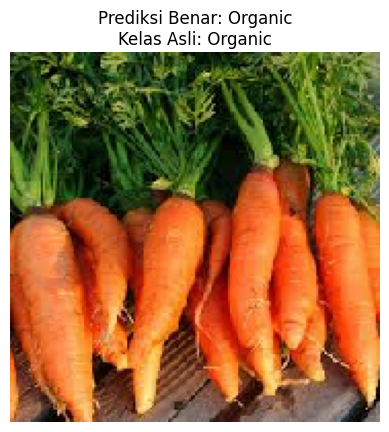

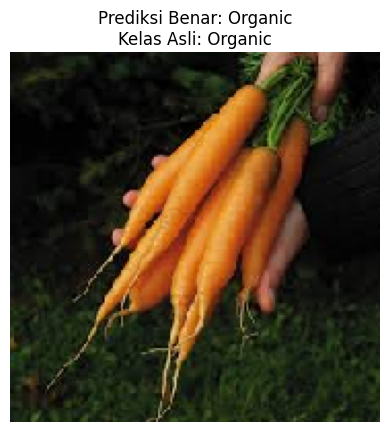

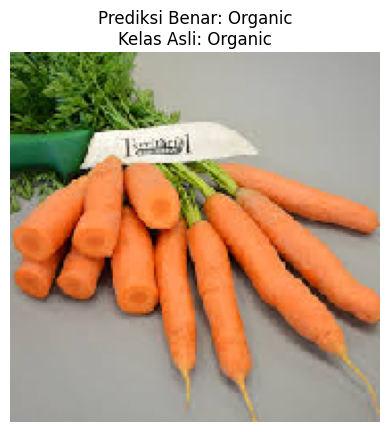

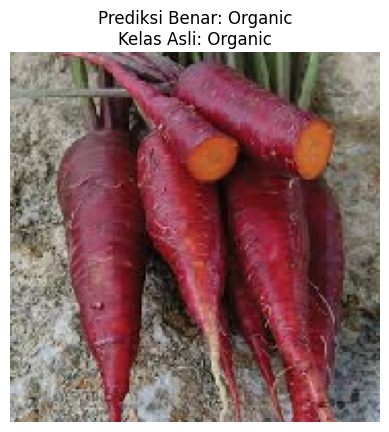

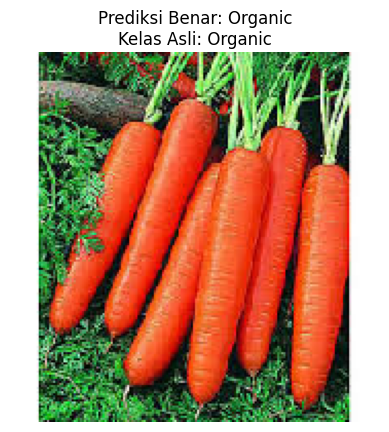

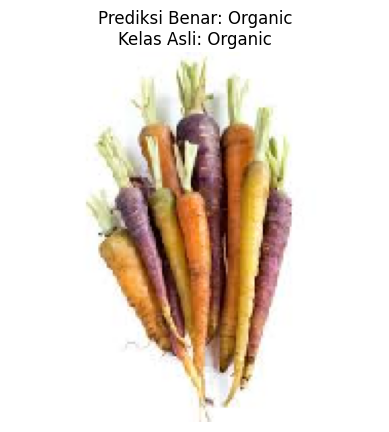

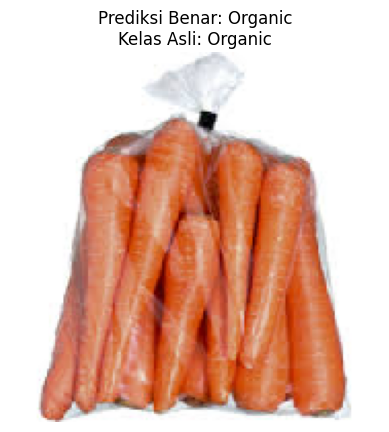

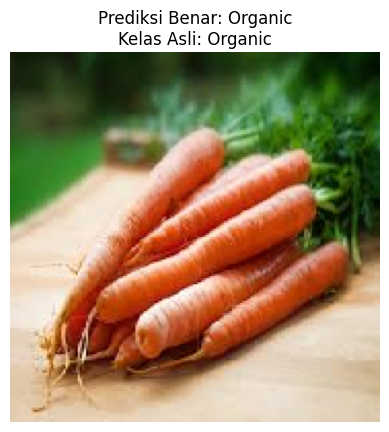

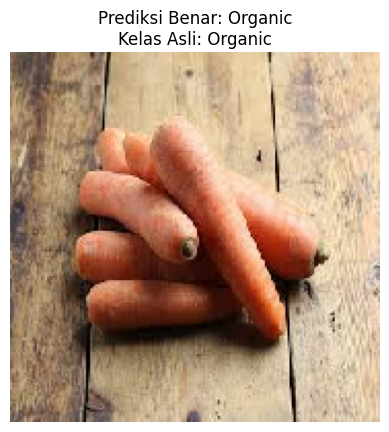

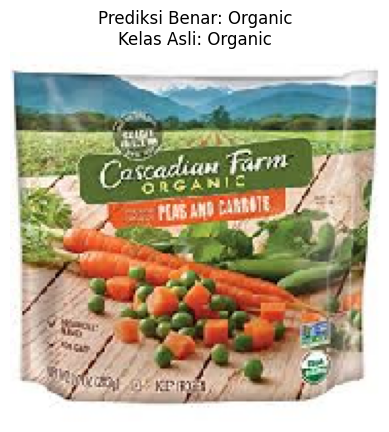

Hasil Prediksi Salah:


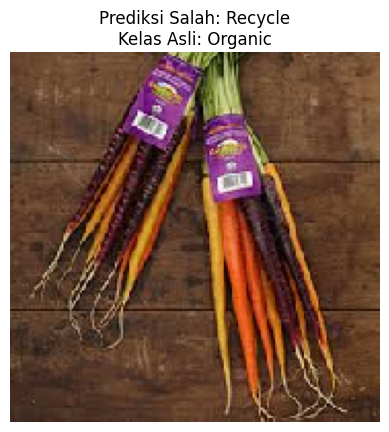

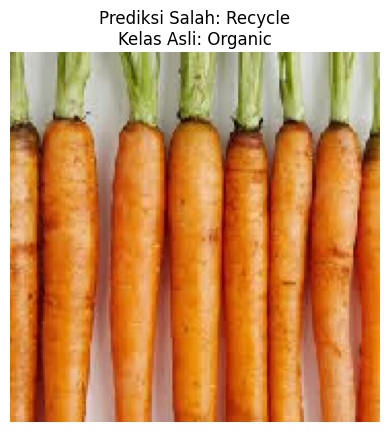

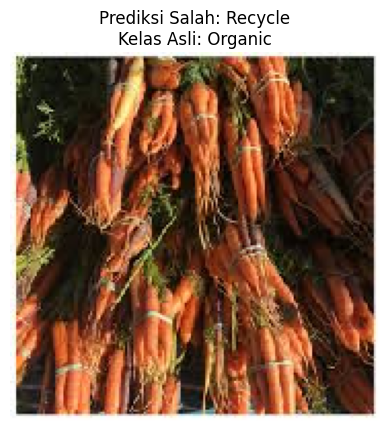

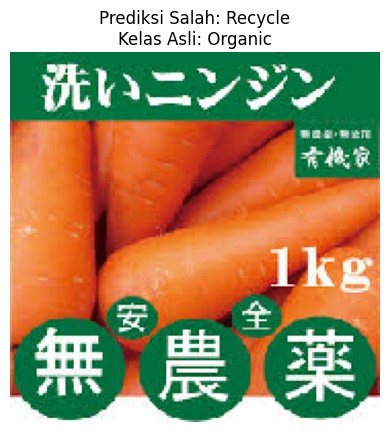

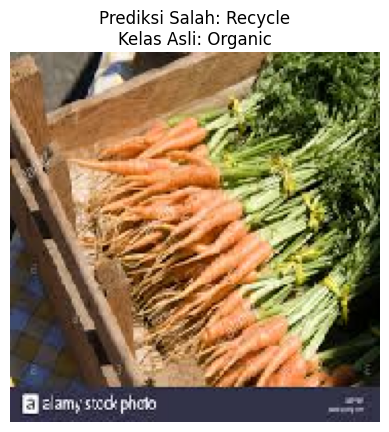

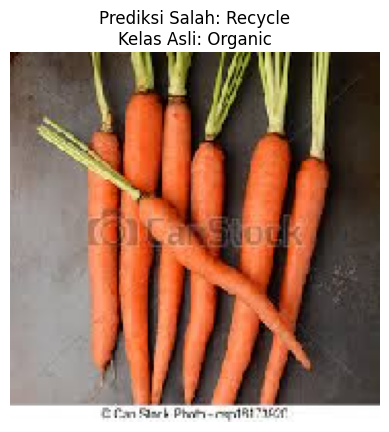

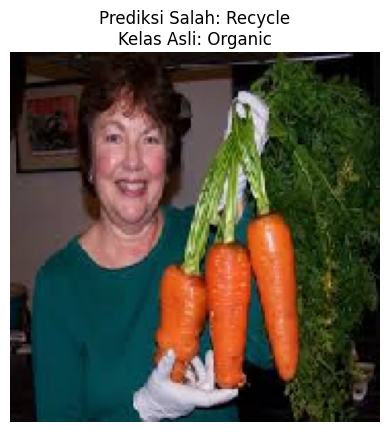

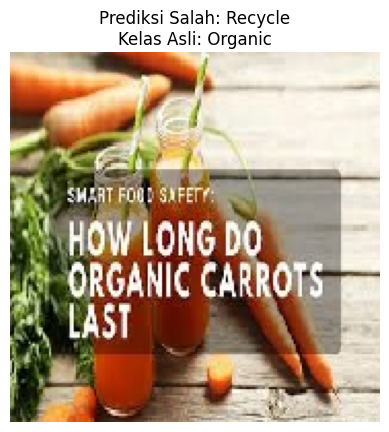

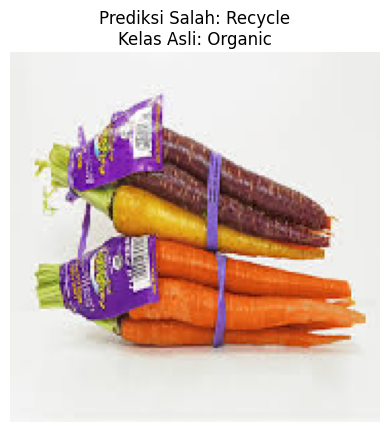

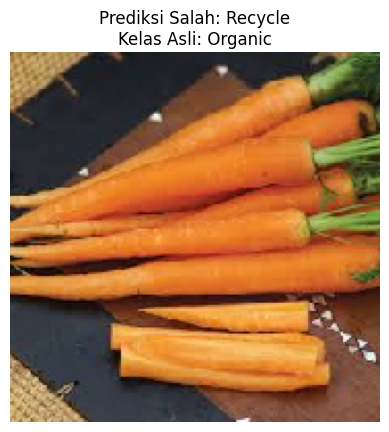

In [41]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Load model yang telah dilatih sebelumnya
model = load_model('/content/drive/MyDrive/fixmodel/final_model9010.h5')
class_names = ['Organic', 'Recycle']

# Mendapatkan prediksi kelas dari model
num_samples = len(test_ds)
test_data = [test_ds[i] for i in range(num_samples)]

# Menyimpan hasil prediksi benar dan salah
correct_predictions = []
wrong_predictions = []

# Maksimal gambar yang akan ditampilkan untuk hasil prediksi benar dan salah
max_images = 10

# Melakukan prediksi dan menyimpan gambar-gambar yang benar dan salah
for data in test_data:
    images = data[0]
    true_labels = data[1]

    # Lakukan prediksi menggunakan model Anda
    predicted_labels = model.predict(images)
    predicted_labels = np.round(predicted_labels)  # Melakukan pembulatan untuk memperoleh prediksi biner

    # Menampilkan setiap gambar dalam batch
    for i in range(images.shape[0]):
        image = images[i]
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        # Mendapatkan kelas yang diprediksi dan kelas asli dalam bentuk array biner
        predicted_classes = np.where(predicted_label == 1)[0]
        true_classes = np.where(true_label == 1)[0]

        # Mendapatkan nama kelas yang diprediksi dan kelas asli
        predicted_class_names = [class_names[idx] for idx in predicted_classes if idx < len(class_names)]
        true_class_names = [class_names[idx] for idx in true_classes if idx < len(class_names)]

        if len(predicted_class_names) > 0:
            predicted_class = predicted_class_names[0]
        else:
            predicted_class = "Unknown"
        true_class = true_class_names[0] if len(true_class_names) > 0 else "Unknown"

        # Menyimpan gambar-gambar hasil prediksi benar dan salah
        if predicted_class == true_class and len(correct_predictions) < max_images:
            correct_predictions.append((image, true_class, predicted_class))
        elif predicted_class != true_class and len(wrong_predictions) < max_images:
            wrong_predictions.append((image, true_class, predicted_class))

# Menampilkan gambar-gambar hasil prediksi benar
print("Hasil Prediksi Benar:")
for image, true_class, predicted_class in correct_predictions:
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediksi Benar: {predicted_class}\nKelas Asli: {true_class}")
    plt.show()

# Menampilkan gambar-gambar hasil prediksi salah
print("Hasil Prediksi Salah:")
for image, true_class, predicted_class in wrong_predictions:
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediksi Salah: {predicted_class}\nKelas Asli: {true_class}")
    plt.show()
